In [15]:
import pandas as pd
import numpy as np
import xgboost
from sklearn import metrics
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from vecstack import stacking
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from sklearn.utils import resample

In [16]:
covid_df = pd.read_csv("dataset.csv")
covid_df.shape
covid_df.head

<bound method NDFrame.head of           Patient ID  Patient age quantile  Hematocrit  Hemoglobin  Platelets  \
0    126e9dd13932f68                    17    0.236515   -0.022340  -0.517413   
1    8bb9d64f0215244                     1   -1.571682   -0.774212   1.429667   
2    6c9d3323975b082                     9   -0.747693   -0.586244  -0.429480   
3    d3ea751f3db9de9                    11    0.991838    0.792188   0.072992   
4    2c2eae16c12a18a                     9    0.190738   -0.147652  -0.668155   
..               ...                   ...         ...         ...        ...   
595  c5b44ff9c7782fd                    19    0.190738    0.165628  -0.102873   
596  88cce1444e16f9c                    19   -0.289922   -0.523588   0.663397   
597  2733fac0d3f7138                    15    0.717175    1.105468  -0.492289   
598  acd761fe16b5d0f                    17   -3.242548   -2.779203  -1.773594   
599  2697fdccbfeb7f7                    19    0.694287    0.541564  -0.906829  

In [37]:
covid_cols = ['Patient age quantile', 'Hematocrit', 'Hemoglobin',
        'Platelets', 'Red blood Cells', 'Lymphocytes', 'Leukocytes',
        'Basophils', 'Eosinophils', 'Monocytes', 'Serum Glucose', 'Neutrophils',
      'Urea', 'Proteina C reativa mg/dL', 'Creatinine', 'Potassium', 'Sodium',
       'Alanine transaminase', 'Aspartate transaminase','Label']

#covid_df = covid_df[covid_cols]
# print(covid_df)



clinicalOutput = covid_df["Label"]
clinicalInput = covid_df.drop(["Patient ID"],axis=1)
# print(clinicalOutput)
# print(clinicalInput)
clinicalInput.shape

(600, 20)

In [38]:
# et = ExtraTreesClassifier(n_estimators=300, max_depth=17),
# rf = RandomForestClassifier(n_estimators=300, max_depth=17),
# #     LogisticRegression(solver = 'saga', max_iter= 500, multi_class='ovr',
# #                         class_weight='balanced')
# xgbc = XGBClassifier(learning_rate=1.0,
#                           n_estimators=300, max_depth=17)


In [39]:
imputer = KNNImputer(n_neighbors=7)
Ximputer = imputer.fit_transform(clinicalInput)
dataframe=pd.DataFrame(Ximputer, columns=covid_cols)

outlier_detect = IsolationForest(n_estimators=150, max_samples=600, contamination=float(0.07), max_features=clinicalInput.shape[1])
dataframe = dataframe.values
outlier_detect.fit(dataframe)


outliers_predicted = outlier_detect.predict(dataframe)
covid_check = dataframe[outlier_detect.predict(dataframe) == -1]
dataframe = dataframe[outlier_detect.predict(dataframe) != -1]

#values = dataframe.values
n_size = int(len(dataframe) * 0.80)

# prepare train and test sets
#data_sample = resample(values, n_samples=n_size)
data_sample = resample(dataframe, n_samples=n_size)

dataframe = pd.DataFrame(data_sample, columns=covid_cols)

    
#split into input and output elements
y = dataframe.Label # Target variable
X = dataframe.drop(['Label'], axis = 1)
# print(X)
# print(clinicalInput.shape[1])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)



sm = SMOTE(k_neighbors=11)
x_res, y_res = sm.fit_resample(X_train, y_train)


In [40]:
import matplotlib.pyplot as plt
plt.rc('font',family='Times New Roman')

In [41]:
from sklearn.svm import SVC
et = ExtraTreesClassifier(n_estimators=300, max_depth=17)
et.fit(x_res, y_res)


ExtraTreesClassifier(max_depth=15, n_estimators=300)

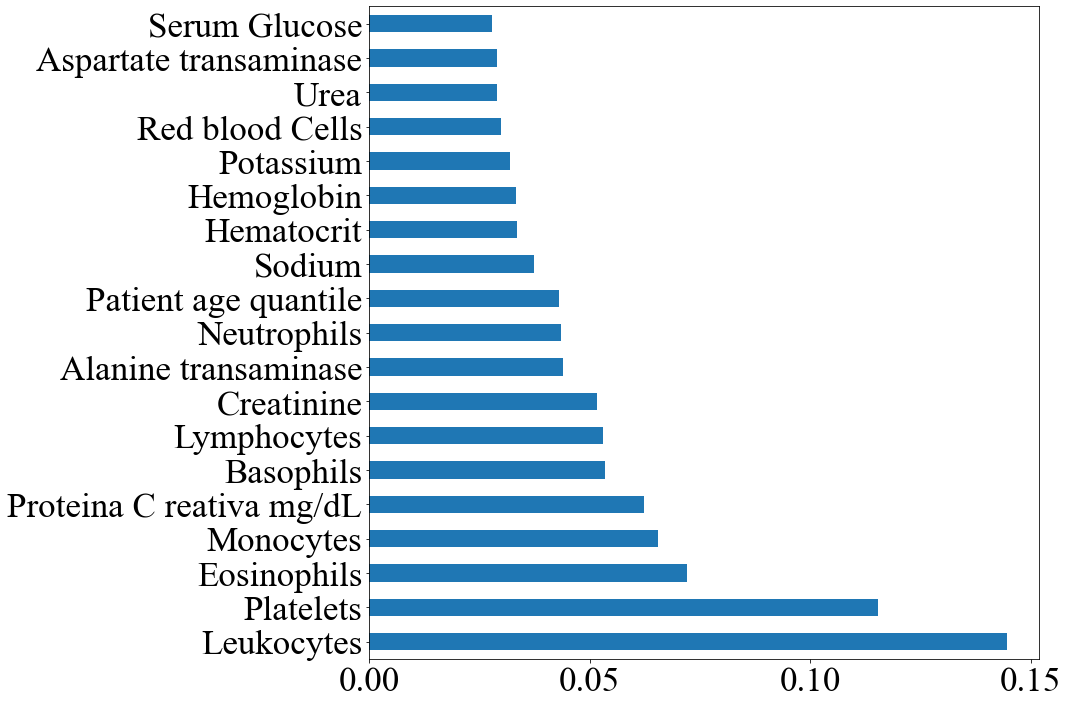

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
feat_importances = pd.Series(et.feature_importances_, index= X.columns)
feat_importances.nlargest(20).plot(kind='barh')
import matplotlib.pyplot as plt
from matplotlib import rcParams

config = {
            "font.family": 'serif',
            "font.size": 35,
            "mathtext.fontset": 'stix',
            "font.serif": ['Times New Roman'],#宋体
#             'axes.unicode_minus': False # 处理负号
         }
rcParams.update(config)
plt.savefig('et11.tif',dpi=600,bbox_inches='tight')

In [105]:
# def imp_df(column_names, importances):
#     df = pd.DataFrame({'feature': column_names,
#     'feature_importance': importances}).sort_values('feature_importance', ascending = False).reset_index(drop = True)
#     return df

In [106]:
# from sklearn.base import clone
# def drop_col_feat_imp(model, X_train, y_train, random_state = 42):
#     # clone the model to have the exact same specification as the one initially trained
#     model_clone = clone(model)
#     # set random_state for comparability
#     model_clone.random_state = random_state
#     # training and scoring the benchmark model
#     model_clone.fit(X_train, y_train)
#     benchmark_score = model_clone.score(X_train, y_train)
#     # list for storing feature importances
#     importances = []
#     # iterating over all columns and storing feature importance (difference between benchmark and new model)
#     for col in X_train.columns:
#         model_clone = clone(model)
#         model_clone.random_state = random_state
#         model_clone.fit(X_train.drop(col, axis = 1), y_train)
#         drop_col_score = model_clone.score(X_train.drop(col, axis = 1), y_train)
#         importances.append(benchmark_score - drop_col_score)
#     importances_df = imp_df(X_train.columns, importances)
#     return importances_df

In [107]:
# drop_col_feat_imp(et,x_res, y_res, random_state = 42)

In [22]:
import shap

Xres_names=pd.DataFrame(data=x_res,columns=X.columns)

shap.initjs()

#model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(Xres_names, label=yres), 100)

explainer = shap.TreeExplainer(et)
shap_values = explainer.shap_values(Xres_names)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
#shap.force_plot(explainer.expected_value, shap_values[0,:], Xres_names.iloc[0,:])


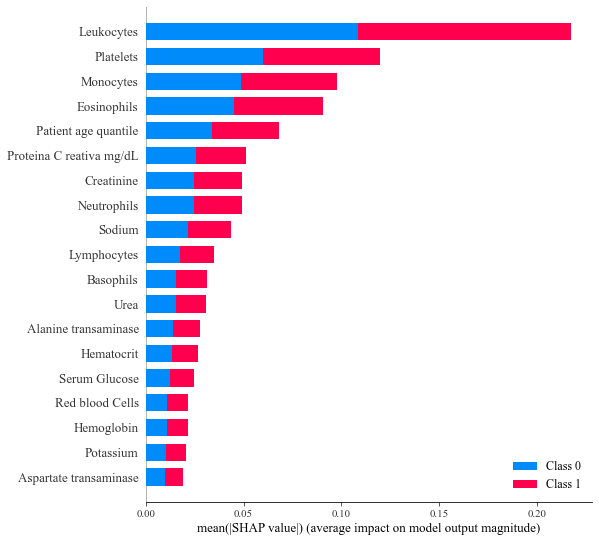

In [24]:
import matplotlib.pyplot as plt
# from matplotlib import rcParams
# config = {
#             "font.family": 'serif',
#             "font.size": 16,
#             "mathtext.fontset": 'stix',
#             "font.serif": ['Times New Roman'],#宋体
#             'axes.unicode_minus': False # 处理负号
#          }
# rcParams.update(config)
import matplotlib.pyplot as plt
shap.summary_plot(shap_values, X, plot_type="bar",show=False)

plt.savefig('et1.tif',dpi=600,bbox_inches='tight')

In [111]:
# train = X.head
# shap_values = explainer.shap_values(X)
# explainer = shap.Explainer(et)
# shap_values = explainer(X)
# shap.plots.waterfall(shap_values)
#shapley_value(X.head(1),model,max_display=10)
#np.array(Xres_names)
#np.array(shap_values)
#shap.dependence_plot('pre_max_overdue_m6', shap_values, data[cols], interaction_index=None, show=False)

In [91]:
# feature_importance = pd.DataFrame()
# feature_importance['feature'] = X.columns
# feature_importance['importance'] = np.abs(shap_values).mean(0)
# feature_importance.sort_values('importance', ascending=False)

In [12]:
shap.force_plot(explainer.expected_value[0], shap_values[0])

Explainer expected value: [0.5 0.5]


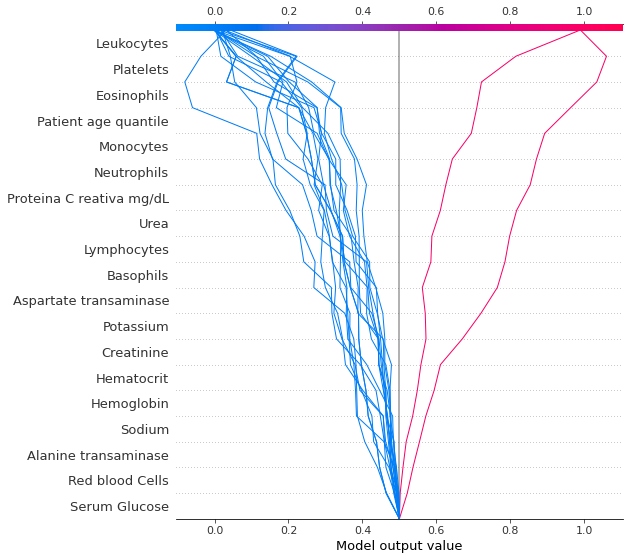

In [17]:
import warnings
explainer = shap.TreeExplainer(et)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = Xres_names.iloc[select]
features_display = Xres_names.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]
    
shap.decision_plot(expected_value[0], shap_values, features_display)

In [44]:
rf = RandomForestClassifier(n_estimators=300, max_depth=17)
#     LogisticRegression(solver = 'saga', max_iter= 500, multi_class='ovr',
#                         class_weight='balanced')
rf.fit(x_res, y_res)

RandomForestClassifier(max_depth=19, n_estimators=90)

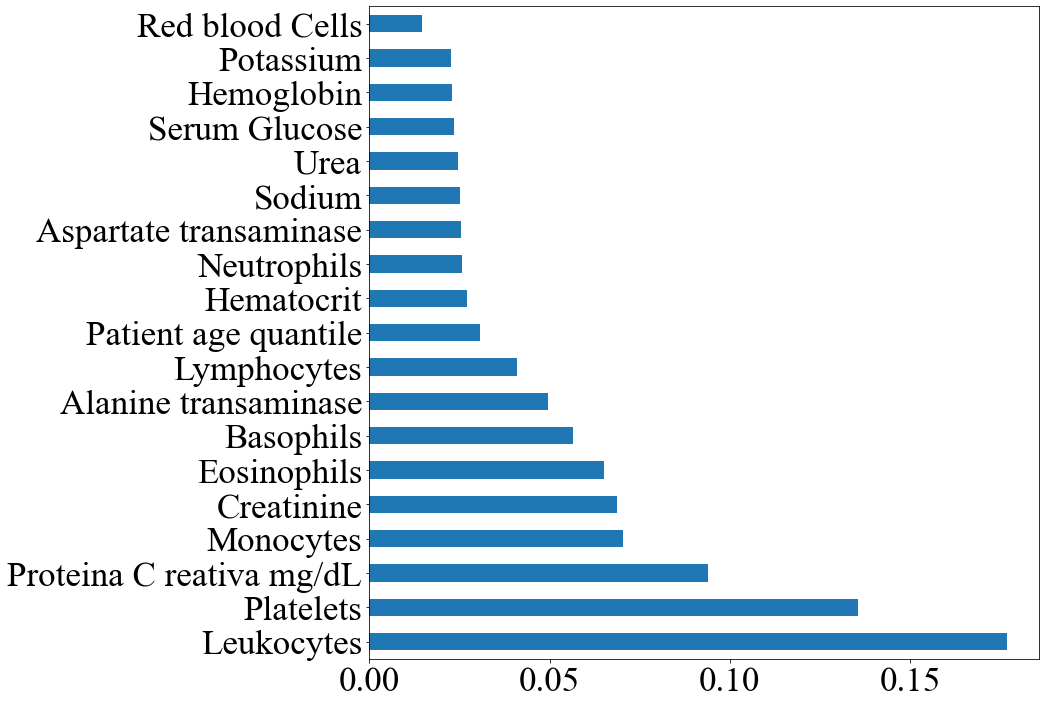

In [45]:
plt.figure(figsize=(12,12))
feat_importances = pd.Series(rf.feature_importances_, index= X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.savefig('rf12.tif',dpi=600,bbox_inches='tight')

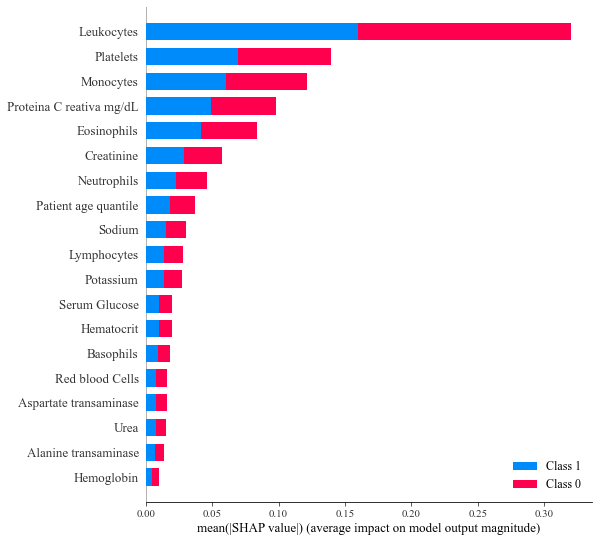

In [32]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(Xres_names)
import matplotlib.pyplot as plt
# from matplotlib import rcParams
# config = {
#             "font.family": 'serif',
#             "font.size": 16,
#             "mathtext.fontset": 'stix',
#             "font.serif": ['Times New Roman'],#宋体
#             'axes.unicode_minus': False # 处理负号
#          }
# rcParams.update(config)
import matplotlib.pyplot as plt
shap.summary_plot(shap_values, X, plot_type="bar",show=False)

plt.savefig('rf1.tif',dpi=600,bbox_inches='tight')

In [34]:
shap.force_plot(explainer.expected_value[0], shap_values[0])

In [21]:
shap.force_plot(explainer.expected_value[0], shap_values[0])

Explainer expected value: [0.49970469 0.50029531]


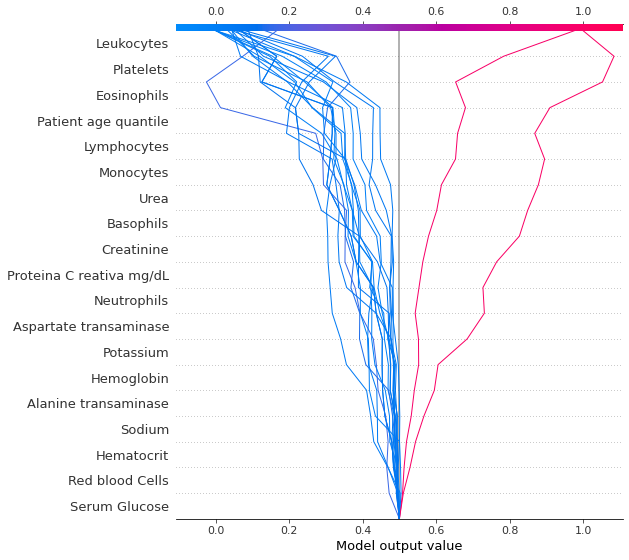

In [22]:
import warnings
explainer = shap.TreeExplainer(rf)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = Xres_names.iloc[select]
features_display = Xres_names.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]
    
shap.decision_plot(expected_value[0], shap_values, features_display)

In [46]:
xgbc = XGBClassifier(learning_rate=0.4,
                          n_estimators=50, max_depth=17, eval_metric='error')
xgbc.fit(x_res, y_res)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=1.0, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=17, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=30, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

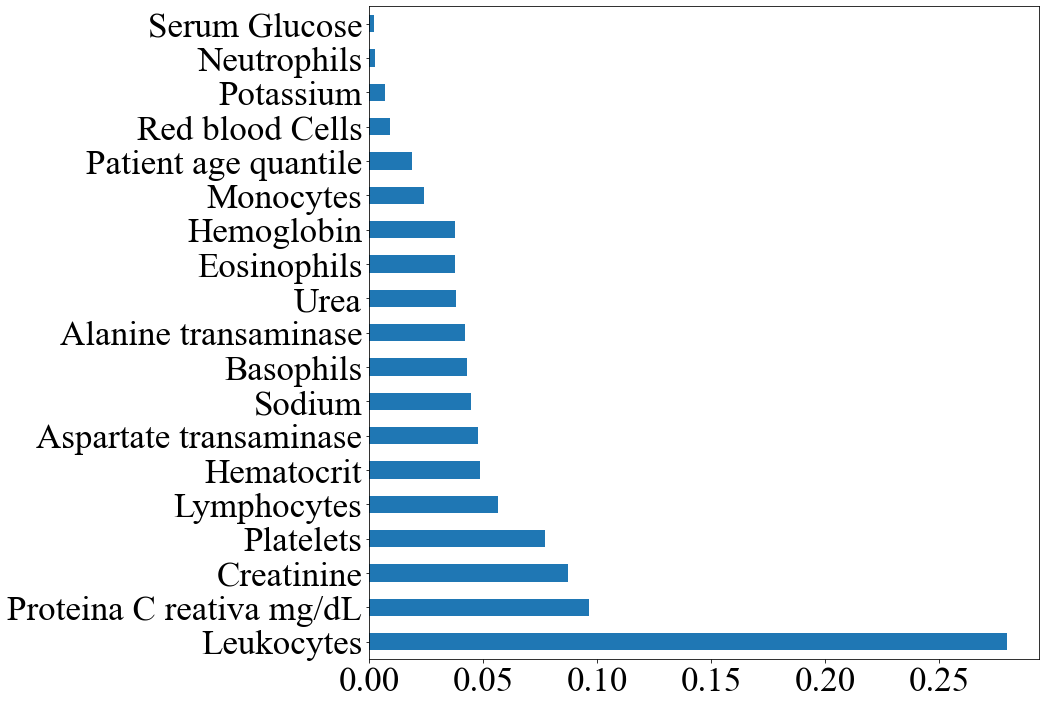

In [47]:
plt.figure(figsize=(12,12))
feat_importances = pd.Series(xgbc.feature_importances_, index= X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.savefig('xgb13.tif',dpi=600,bbox_inches='tight')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


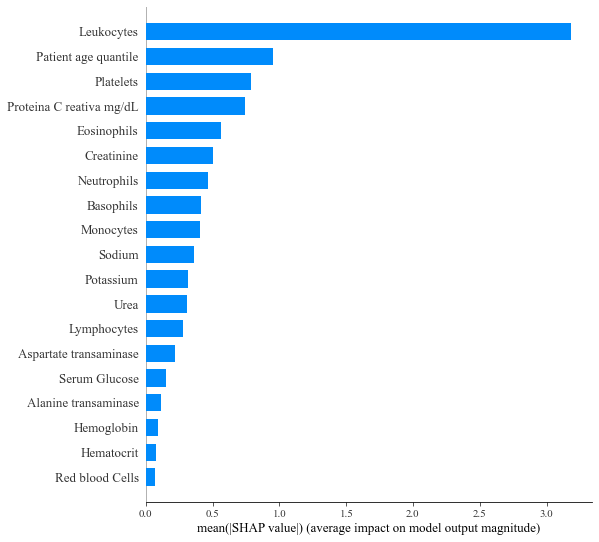

In [34]:
explainer = shap.TreeExplainer(xgbc)
shap_values = explainer.shap_values(Xres_names)
import matplotlib.pyplot as plt
# from matplotlib import rcParams
# config = {
#             "font.family": 'serif',
#             "font.size": 16,
#             "mathtext.fontset": 'stix',
#             "font.serif": ['Times New Roman'],#宋体
#             'axes.unicode_minus': False # 处理负号
#          }
# rcParams.update(config)
import matplotlib.pyplot as plt
shap.summary_plot(shap_values, X, plot_type="bar",show=False)

plt.savefig('xgb1.tif',dpi=600,bbox_inches='tight')

In [23]:
shap.plots.force(explainer.expected_value,shap_values[0])

Explainer expected value: [-0.05163409]


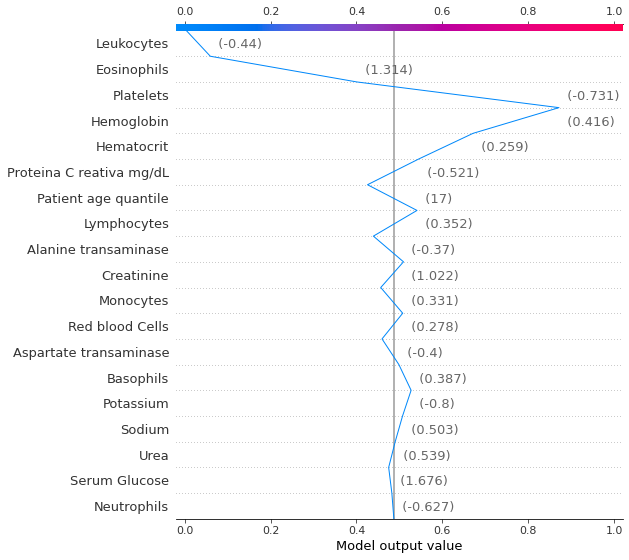

In [27]:
import warnings
explainer = shap.TreeExplainer(xgbc)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = Xres_names.iloc[select]
features_display = Xres_names.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]
    
shap.decision_plot(expected_value, shap_values, features_display, link ='logit')

Explainer expected value: [-0.05163409]


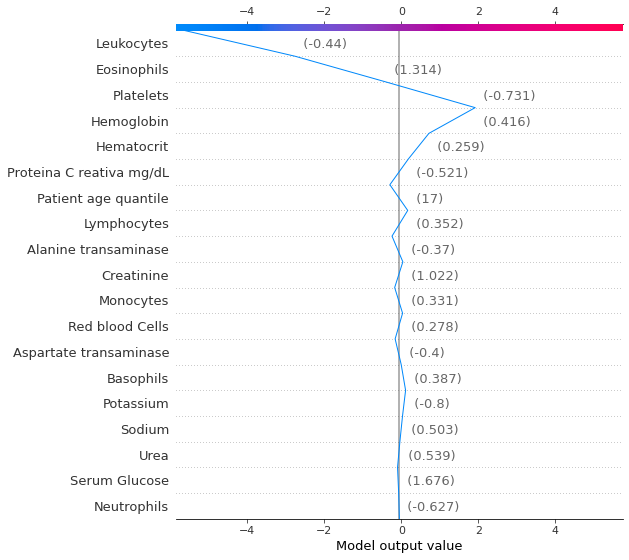

In [28]:
import warnings
explainer = shap.TreeExplainer(xgbc)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = Xres_names.iloc[select]
features_display = Xres_names.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]
    
shap.decision_plot(expected_value[0], shap_values, features_display)

In [48]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=290,max_depth=8, min_samples_leaf =20, 
               min_samples_split =200, max_features='sqrt', random_state=10,subsample=0.8)
gb.fit(x_res, y_res)

GradientBoostingClassifier(max_depth=11, max_features=11, min_samples_leaf=30,
                           min_samples_split=100, n_estimators=290,
                           random_state=10, subsample=0.85)

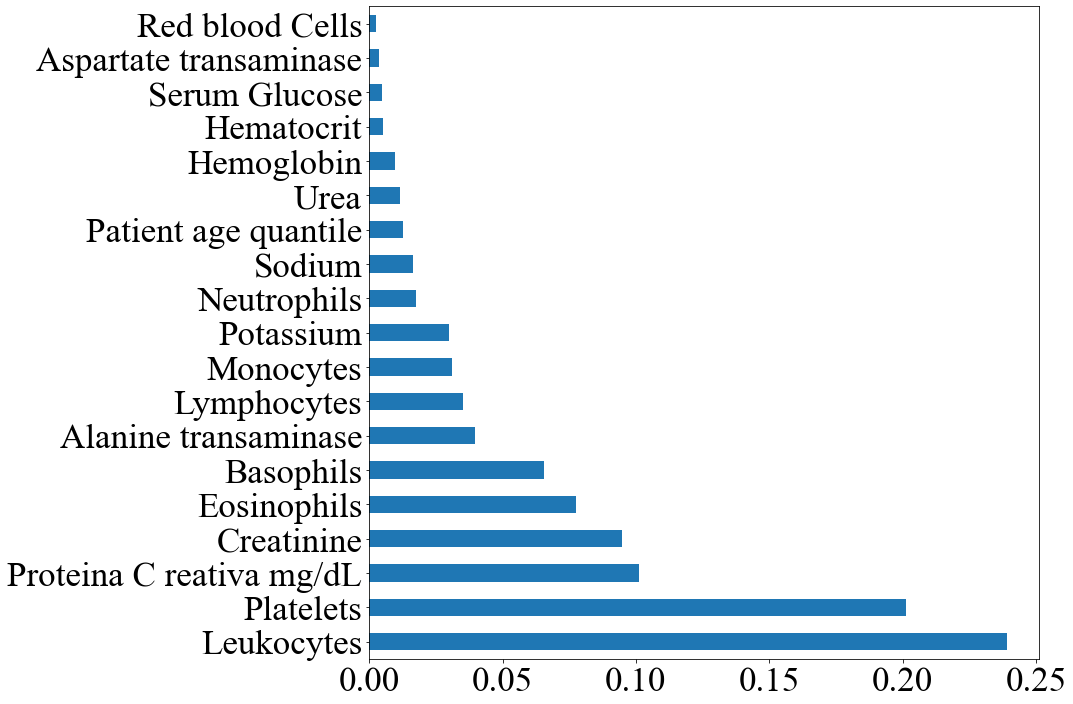

In [49]:
plt.figure(figsize=(12,12))
feat_importances = pd.Series(gb.feature_importances_, index= X.columns)
feat_importances.nlargest(20).plot(kind='barh')
import matplotlib.pyplot as plt
plt.savefig('gbdt14.tif',dpi=600,bbox_inches='tight')

Explainer expected value: [-0.56461516]


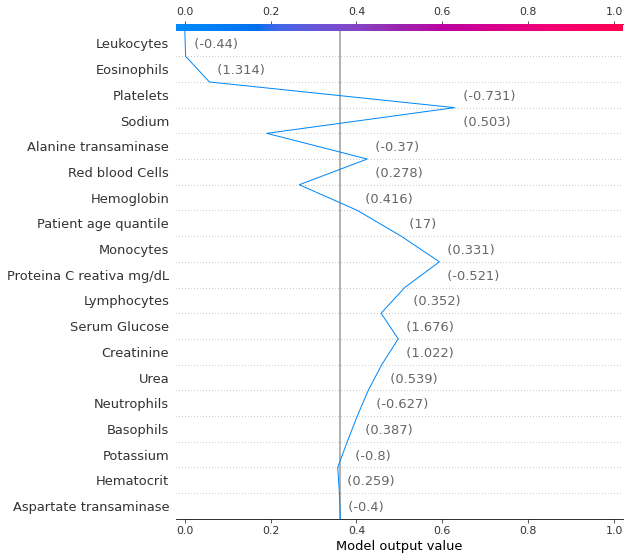

In [33]:
import warnings
explainer = shap.TreeExplainer(gb)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(20)
features = Xres_names.iloc[select]
features_display = Xres_names.loc[features.index]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer.shap_values(features)[1]
    shap_interaction_values = explainer.shap_interaction_values(features)
if isinstance(shap_interaction_values, list):
    shap_interaction_values = shap_interaction_values[1]
    
shap.decision_plot(expected_value, shap_values, features_display, link ='logit')

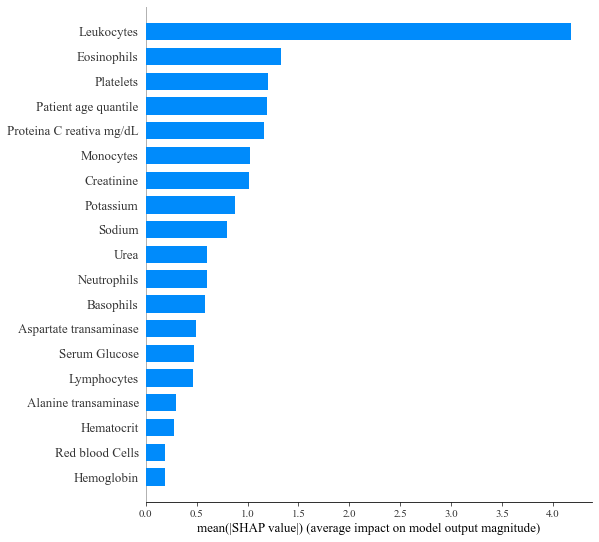

In [36]:
explainer = shap.TreeExplainer(gb)
shap_values = explainer.shap_values(Xres_names)
import matplotlib.pyplot as plt
# from matplotlib import rcParams
# config = {
#             "font.family": 'serif',
#             "font.size": 16,
#             "mathtext.fontset": 'stix',
#             "font.serif": ['Times New Roman'],#宋体
#             'axes.unicode_minus': False # 处理负号
#          }
# rcParams.update(config)
import matplotlib.pyplot as plt
shap.summary_plot(shap_values, X, plot_type="bar",show=False)

plt.savefig('gbdt1.tif',dpi=600,bbox_inches='tight')